# Gradient Descent method with Newton

### Load libraries

In [173]:
# Base libraries
import numpy as np
import pandas as pd

# Plot libraries
import matplotlib.pyplot as plt

# Math libraries
import math

### Load dataset

In [174]:
# Load the dataset
dataset = pd.read_csv("Data/student_habits_performance_clean.csv", encoding='utf-8')
target_col = 'exam score [scale 1-10]'
print(dataset.columns.tolist())


['student_id', 'age [years]', 'gender', 'study hours per day', 'social media hours', 'Netflix hours', 'part_time_job', 'attendance percentage', 'sleep hours', 'diet_quality', 'exercise frequency [times/week]', 'parental_education_level', 'internet_quality', 'mental health rating [scale 1-10]', 'extracurricular_participation', 'exam score [scale 1-10]']


### Definiton of the functions

In [175]:
# Standardize data to mean 0 and std dev 1
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

# Get regression data in matrix form
def build_model_data(x, y):
    b = y
    num_samples = len(b)
    A = np.c_[np.ones(num_samples), x]  # Add intercept column
    return A, b

# Select all numeric columns except 'student_id' and target
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()
if 'student_id' in numeric_cols:
    numeric_cols.remove('student_id')
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

# Extract features and target
features = dataset[numeric_cols].values
target = dataset[target_col].values

# Standardize all numeric features and target
features_standardized = np.apply_along_axis(standardize, 0, features)
target_standardized = standardize(target)

# Build model data matrix A and vector b
A, b = build_model_data(features_standardized, target_standardized)

# Objective function
def calculate_objective(Axmb):
    return 0.5 * np.sum(Axmb ** 2)

# Gradient computation
def compute_gradient(A, x, b):
    Axmb = A @ x - b
    grad = A.T @ Axmb
    return grad, Axmb

# Newton's method
H = A.T @ A
def newton_method(A, initial_x, b, max_iters, tol=1e-6):
    xs = [initial_x]
    objectives = []
    x = initial_x.copy()

    # Precompute Hessian and its inverse
    try:
        H_inv = np.linalg.inv(H)
    except np.linalg.LinAlgError:
        print("⚠️ Hessian is singular. Using pseudo-inverse.")
        H_inv = np.linalg.pinv(H)

    for n_iter in range(max_iters):
        grad, Axmb = compute_gradient(A, x, b)
        obj = calculate_objective(Axmb)

        x = x - H_inv @ grad

        xs.append(x)
        objectives.append(obj)

        print("Newton({}/{}) | objective={:.5f}".format(n_iter, max_iters, obj))

        if n_iter > 0 and abs(objectives[-1] - objectives[-2]) < tol:
            print(f"\n-----> Convergence reached after {n_iter-1} iterations.")
            break

    return objectives, xs

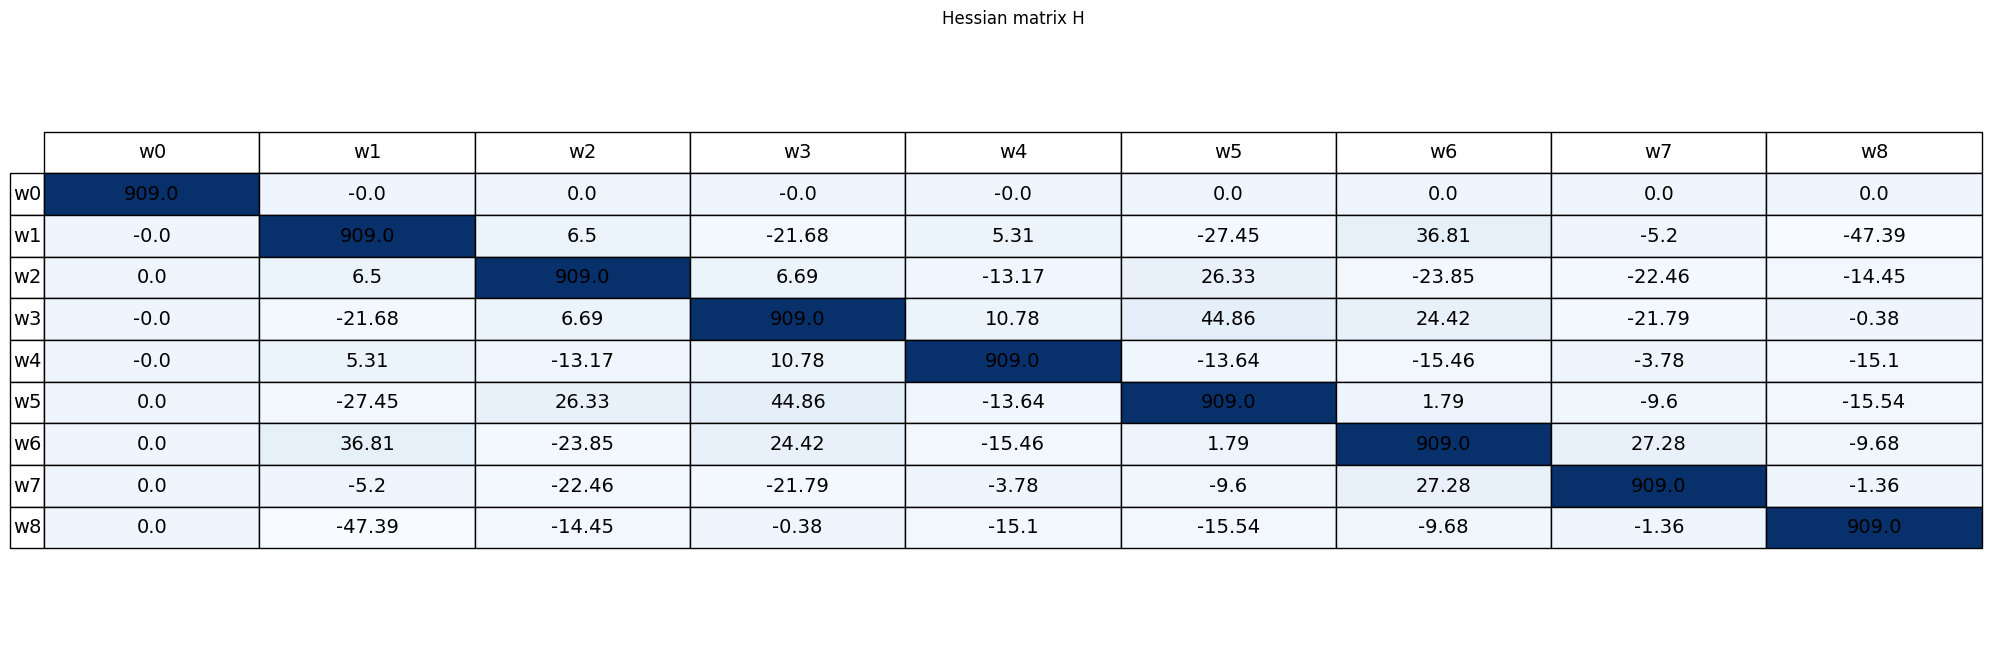

In [176]:
import matplotlib.colors as mcolors

H_rounded = np.round(H, 2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')

norm = mcolors.Normalize(vmin=np.min(H_rounded), vmax=np.max(H_rounded))
cmap = plt.cm.Blues

cell_colors = []
for row in H_rounded:
    cell_colors.append([cmap(norm(value)) for value in row])

table = ax.table(cellText=H_rounded,
                 rowLabels=[f'w{i}' for i in range(H.shape[0])],
                 colLabels=[f'w{i}' for i in range(H.shape[1])],
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(14)

table.scale(2.5, 2.5)

plt.title("Hessian matrix H")
plt.show()

In [177]:
det_H = np.linalg.det(H)
print("Determinant of Hessian:", det_H)

if det_H != 0:
    print("Hessian is invertible")
else:
    print("Hessian is singular (not invertible)")

Determinant of Hessian: 4.175008364931685e+26
Hessian is invertible


In [178]:
# Run Newton method
x_initial = np.zeros(A.shape[1])
max_iters = 100

objectives, xs = newton_method(A, x_initial, b, max_iters)

Newton(0/100) | objective=454.50000
Newton(1/100) | objective=45.51048
Newton(2/100) | objective=45.51048

-----> Convergence reached after 1 iterations.


# Performance

This strong performance is expected based on theory, since the loss function we are minimizing is quadratic.

$$
f(x) = \frac{1}{2} \|Ax - b\|^2
$$
 
Since this is a convex quadratic function, Newton's Method is guaranteed to converge in a single step if we start at a reasonable point and compute the exact Hessian inverse.

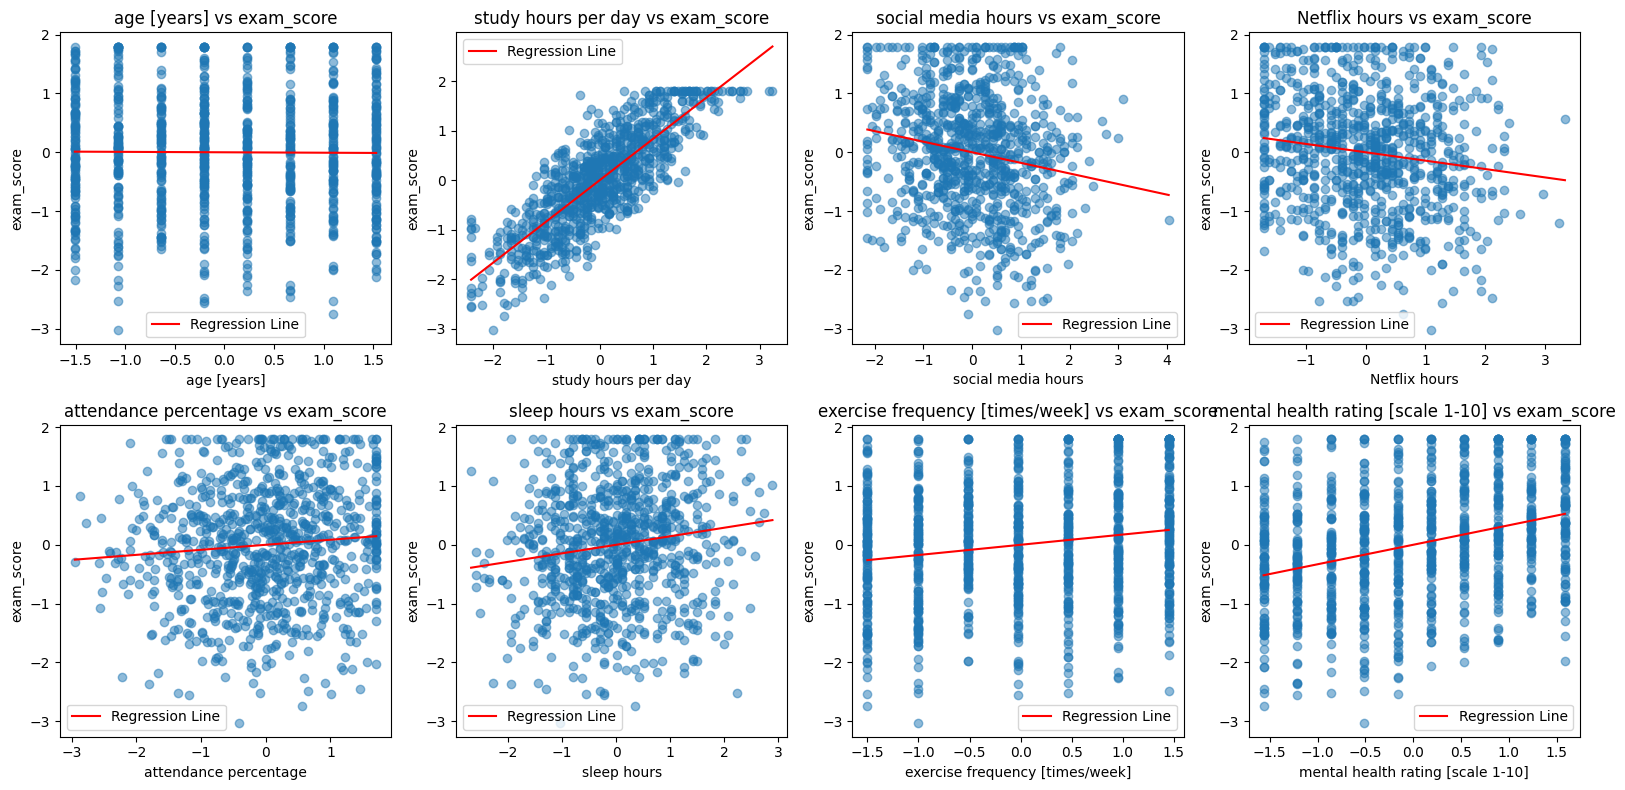

In [179]:
# final weights from Newton's method
w_star = xs[-1]

num_features = A.shape[1] - 1
num_cols = 4
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
axes = axes.flatten()

for i in range(num_features):
    x_i = A[:, i+1]
    y = b

    axes[i].scatter(x_i, y, alpha=0.5)
    axes[i].set_xlabel(numeric_cols[i])
    axes[i].set_ylabel('exam_score')
    axes[i].set_title(f'{numeric_cols[i]} vs exam_score')

    # line with predicted values
    x_vals = np.array([x_i.min(), x_i.max()])
    y_vals = w_star[0] + w_star[i+1] * x_vals

    axes[i].plot(x_vals, y_vals, color='red', label='Regression Line')
    axes[i].legend()

# remove extra subplots
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

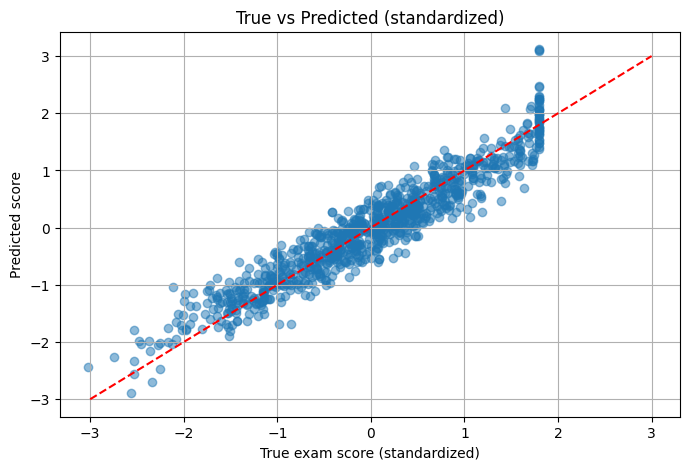

In [180]:
y_pred = A @ w_star

plt.figure(figsize=(8, 5))
plt.scatter(b, y_pred, alpha=0.5)
plt.plot([-3, 3], [-3, 3], 'r--')
plt.title("True vs Predicted (standardized)")
plt.xlabel("True exam score (standardized)")
plt.ylabel("Predicted score")
plt.grid(True)
plt.show()